# Part 0. Description

This script is a part of our work on the intepretation of machine learning models in neuroimaging. See more [details](https://github.com/cocoanlab/interpret_ml_neuroimaging)

In this example, we will classify **Heat pain trial** and **Rejection trial** fMRI data using Convolutional Neural Network (CNN) and we will use Layer-wise Relevance Propagation (LRP) [(Bach et al., 2015)](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0130140) to explain the predictions of the model. 

The data consists of **59 subjects**. Each subject has **8 heat trials** and **8 rejection trials**.

We will do Leave-One-Subject-Out cross-validation which means 59-fold cross-validation will be executed. In order to track which subject is held-out as a test set, we save the model number matched with the subject number. For example, if `sub_01` is the test set (first fold cross-validation), then model name is `model_01`

Since we have 59 folds's results and models, it will be difficult to manage all of them. So we will use data matrix so that we can easily handle the results and models.

When initialized, the data matrix contains: `'data_path'`(**where the data is saved**), `'type'`(**which type of stimulus is used on this data**), `'type_onehot'`(**One-Hot encoding of type**), `'subject'`(**subject number**)

After the CNN model training, the following columns will be added:

`'predicted_type_onehot'`(**predicted type by trained CNN model**), `'model_name'`(**which model is used for prediction**), `'model_weight_path'`(**where the model weight is saved**), `'model_acc'`(**accuracy of model for test data sets**), `'model_loss'`(**loss of model for test data sets**)

In [20]:
#The following is an example of the output data matrix of this script. Do not execute this cell before you train CNN models.
df.head(n=20)

index                                          data_path  type  \
0       0  ../data/derivatives/trial_images/sub_01/heat_t...  heat   
1       1  ../data/derivatives/trial_images/sub_01/heat_t...  heat   
2       2  ../data/derivatives/trial_images/sub_01/heat_t...  heat   
3       3  ../data/derivatives/trial_images/sub_01/heat_t...  heat   
4       4  ../data/derivatives/trial_images/sub_01/heat_t...  heat   
5       5  ../data/derivatives/trial_images/sub_01/heat_t...  heat   
6       6  ../data/derivatives/trial_images/sub_01/heat_t...  heat   
7       7  ../data/derivatives/trial_images/sub_01/heat_t...  heat   
8       8  ../data/derivatives/trial_images/sub_02/heat_t...  heat   
9       9  ../data/derivatives/trial_images/sub_02/heat_t...  heat   
10     10  ../data/derivatives/trial_images/sub_02/heat_t...  heat   
11     11  ../data/derivatives/trial_images/sub_02/heat_t...  heat   
12     12  ../data/derivatives/trial_images/sub_02/heat_t...  heat   
13     13  ../data/derivatives/trial_images/sub_02/heat_t...  heat   
14     14  ../data/derivatives/trial_images/sub_02/heat_t...  heat   
15     15  ../data/derivatives/trial_images/sub_02/heat_t...  heat   
16     16  ../data/derivatives/trial_images/sub_03/heat_t...  heat   
17     17  ../data/derivatives/trial_images/sub_03/heat_t...  heat   
18     18  ../data/derivatives/trial_images/sub_03/heat_t...  heat   
19     19  ../data/derivatives/trial_images/sub_03/heat_t...  heat   

    type_onehot subject predicted_type_onehot model_name  \
0             1  sub_01                     1   model_01   
1             1  sub_01                     1   model_01   
2             1  sub_01                     1   model_01   
3             1  sub_01                     1   model_01   
4             1  sub_01                     1   model_01   
5             1  sub_01                     1   model_01   
6             1  sub_01                     0   model_01   
7             1  sub_01                     1   model_01   
8             1  sub_02                     1   model_02   
9             1  sub_02                     1   model_02   
10            1  sub_02                     1   model_02   
11            1  sub_02                     1   model_02   
12            1  sub_02                     1   model_02   
13            1  sub_02                     1   model_02   
14            1  sub_02                     1   model_02   
15            1  sub_02                     1   model_02   
16            1  sub_03                     1   model_03   
17            1  sub_03                     1   model_03   
18            1  sub_03                     1   model_03   
19            1  sub_03                     1   model_03   

                                    model_weight_path model_acc model_loss  
0   /home/cocoan-gpu1/Documents/interpret_ml_neuro...    0.9375  0.0564367  
1   /home/cocoan-gpu1/Documents/interpret_ml_neuro...    0.9375  0.0564367  
2   /home/cocoan-gpu1/Documents/interpret_ml_neuro...    0.9375  0.0564367  
3   /home/cocoan-gpu1/Documents/interpret_ml_neuro...    0.9375  0.0564367  
4   /home/cocoan-gpu1/Documents/interpret_ml_neuro...    0.9375  0.0564367  
5   /home/cocoan-gpu1/Documents/interpret_ml_neuro...    0.9375  0.0564367  
6   /home/cocoan-gpu1/Documents/interpret_ml_neuro...    0.9375  0.0564367  
7   /home/cocoan-gpu1/Documents/interpret_ml_neuro...    0.9375  0.0564367  
8   /home/cocoan-gpu1/Documents/interpret_ml_neuro...      0.75   0.808878  
9   /home/cocoan-gpu1/Documents/interpret_ml_neuro...      0.75   0.808878  
10  /home/cocoan-gpu1/Documents/interpret_ml_neuro...      0.75   0.808878  
11  /home/cocoan-gpu1/Documents/interpret_ml_neuro...      0.75   0.808878  
12  /home/cocoan-gpu1/Documents/interpret_ml_neuro...      0.75   0.808878  
13  /home/cocoan-gpu1/Documents/interpret_ml_neuro...      0.75   0.808878  
14  /home/cocoan-gpu1/Documents/interpret_ml_neuro...      0.75   0.808878  
15  /home/cocoan-gpu1/Documents/interpre

# Part 1. Initializing Data Matrix

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nilearn import image
import nipype.interfaces.io as nio
import os

import tensorflow as tf
from sklearn.model_selection import LeaveOneGroupOut
from keras.models import load_model

%matplotlib inline

Setting base directory(`datapath`) for searching files and saving results(`result_path`, `dataframe_filename`)

In [28]:
datapath = '../data/derivatives/trial_images'
result_path = '../results/test2_avg_trial_lrp'
dataframe_filename = 'cnn_lrp_dataframe.csv'

This is a template of files that you want to find in the base directory(`datapath`).

In [29]:
heat_search_template = 'sub_*/heat*.nii'
rejection_search_template = 'sub_*/rejection*.nii'

We will use `nipype.interfaces.io.DataGrabber()` to get the list of the files in the  directory.

If you want to know the details of `DataGrabber()`, see this [reference](https://miykael.github.io/nipype_tutorial/notebooks/basic_data_input.html)

In [30]:
datasource = nio.DataGrabber()
datasource.inputs.base_directory = datapath
datasource.inputs.template = heat_search_template
datasource.inputs.sort_filelist = True
heat_imgs = datasource.run().outputs.get()['outfiles']

datasource.inputs.template = rejection_search_template
rejection_imgs = datasource.run().outputs.get()['outfiles']

all_imgs = np.concatenate((np.array(heat_imgs, dtype=object), np.array(rejection_imgs, dtype=object)))

Change data path from absolute to relative

In [31]:
def abs_path_to_rel(abs_path, break_point):
    split_path_list = []
    
    while True:
        abs_path, split_path = os.path.split(abs_path)
        split_path_list.append(split_path)

        if break_point in split_path:
            break

    for i in range(len(split_path_list)):
        if i == 0:
            rel_path = os.path.join('..', split_path_list[-(i+1)])
        else:
            rel_path = os.path.join(rel_path, split_path_list[-(i+1)])
            
    return rel_path

In [32]:
rel_all_imgs = []
for i in range(len(all_imgs)):
    rel_img_path = abs_path_to_rel(all_imgs[i], 'data')
    rel_all_imgs.append(rel_img_path)

Initializing data matrix(`df`) with columns `data_path`, `type`, `type_onehot`, `subject`.

In [33]:
df = pd.DataFrame(rel_all_imgs, columns=['data_path'])
df['type']= None
df['type_onehot'] = None
df['subject']= None

This is basic usage of `Pandas`. If you are not familiar with `Pandas`, see 

[*Getting started*](https://pandas.pydata.org/pandas-docs/stable/getting_started/index.html)

[`pandas.Series.str.find`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.find.html) 

[`pandas.Series.str.extract`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.extract.html)

In [34]:
df.loc[df[df['data_path'].str.find('heat')!=-1].index, 'type'] = 'heat'
df.loc[df[df['data_path'].str.find('reject')!=-1].index, 'type'] = 'reject'
df.loc[df[df['data_path'].str.find('heat')!=-1].index, 'type_onehot'] = 1
df.loc[df[df['data_path'].str.find('reject')!=-1].index, 'type_onehot'] = 0
df['subject'] = df['data_path'].str.extract(r'(sub_\d\d)')

df = df.replace(to_replace='None', value=np.nan).dropna()
df.reset_index(inplace=True)

You can see the first **n** rows of data matrix using `df.head(n=n)`

Since we have not trained the CNN model nor performed LRP, the data matrix contains only details about our input data.  As we go further through the script, more columns will be added.

In [9]:
df.head(n=20)

index                                          data_path  type  \
0       0  ../data/derivatives/trial_images/sub_01/heat_t...  heat   
1       1  ../data/derivatives/trial_images/sub_01/heat_t...  heat   
2       2  ../data/derivatives/trial_images/sub_01/heat_t...  heat   
3       3  ../data/derivatives/trial_images/sub_01/heat_t...  heat   
4       4  ../data/derivatives/trial_images/sub_01/heat_t...  heat   
5       5  ../data/derivatives/trial_images/sub_01/heat_t...  heat   
6       6  ../data/derivatives/trial_images/sub_01/heat_t...  heat   
7       7  ../data/derivatives/trial_images/sub_01/heat_t...  heat   
8       8  ../data/derivatives/trial_images/sub_02/heat_t...  heat   
9       9  ../data/derivatives/trial_images/sub_02/heat_t...  heat   
10     10  ../data/derivatives/trial_images/sub_02/heat_t...  heat   
11     11  ../data/derivatives/trial_images/sub_02/heat_t...  heat   
12     12  ../data/derivatives/trial_images/sub_02/heat_t...  heat   
13     13  ../data/derivatives/trial_images/sub_02/heat_t...  heat   
14     14  ../data/derivatives/trial_images/sub_02/heat_t...  heat   
15     15  ../data/derivatives/trial_images/sub_02/heat_t...  heat   
16     16  ../data/derivatives/trial_images/sub_03/heat_t...  heat   
17     17  ../data/derivatives/trial_images/sub_03/heat_t...  heat   
18     18  ../data/derivatives/trial_images/sub_03/heat_t...  heat   
19     19  ../data/derivatives/trial_images/sub_03/heat_t...  heat   

    type_onehot subject  
0             1  sub_01  
1             1  sub_01  
2             1  sub_01  
3             1  sub_01  
4             1  sub_01  
5             1  sub_01  
6             1  sub_01  
7             1  sub_01  
8             1  sub_02  
9             1  sub_02  
10            1  sub_02  
11            1  sub_02  
12            1  sub_02  
13            1  sub_02  
14            1  sub_02  
15            1  sub_02  
16            1  sub_03  
17            1  sub_03  
18            1  sub_03  
19            1  sub_03

# Part 2. Loading Data Function

The following code defines a function that we will use later to load data.

In [35]:
def load_dat(df, train_index, test_index, transpose_index=[3,2,1,0], do_masking=False, mask_path=None, do_masker = False):

    #Extract data path and labels from data matrix
    tr_path_X, te_path_X = df['data_path'][train_index].to_numpy(), df['data_path'][test_index].to_numpy()
    train_y, test_y = df['type_onehot'][train_index].to_numpy(), df['type_onehot'][test_index].to_numpy()
    
    from nilearn import image    
    
    if not do_masking:
        train_X = image.load_img(tr_path_X).get_fdata()
        test_X = image.load_img(te_path_X).get_fdata()
    
    elif do_masking:
        if do_masking and mask_path==None:
            raise ValueError('For masking, you need to set mask_path')
            
        from nilearn.masking import apply_mask, unmask
        from nilearn.image import resample_to_img
        from nilearn.input_data import NiftiMasker
            
        mask_img = image.load_img(mask_path)
        
        tr_X = image.load_img(tr_path_X)
        te_X = image.load_img(te_path_X)
        
        temp_img = image.load_img(tr_path_X[0])
        mask_img = resample_to_img(mask_img, temp_img, interpolation='nearest')
        
        #Extract bool mask from epi mask image
        if do_masker:
            masker = NiftiMasker(mask_strategy='epi')
            fitted_masker = masker.fit(mask_img)
            mask_img = fitted_masker.mask_img_
        
        tr_X = unmask(apply_mask(tr_X ,mask_img), mask_img)
        te_X = unmask(apply_mask(te_X ,mask_img), mask_img)
        
        train_X = tr_X.get_fdata()
        test_X = te_X.get_fdata()
    
    #Transpose matrix in order to match CNN model's input layer
    #Keras(or Tensorflow) is using (Number of data, height, width, channel) data shape for 2D image(https://keras.io/layers/convolutional/) and channel will be 'cutting axis'.
    #For brain images, nibabel using (x[left/Right;], y[posterior/Anterior], z[inferior/Superior], Number of data) data shape(https://nipy.org/nibabel/coordinate_systems.html).
    #You need to decide which axis will be cutting axis(like channel).
    #In this example, we choose 'x' axis as a cutting axis.
    #[x, y, z, N] => [N, z, y, x], ([79, 95, 68, N] => [N, 68, 95, 79])
    train_X = train_X.transpose(transpose_index)
    test_X = test_X.transpose(transpose_index)
    fmri_shape = train_X.shape[1:]
    
    return train_X, train_y, test_X, test_y, fmri_shape

# Part 3. CNN Model

In [36]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')

We are using `Keras` for making CNN models

You can see details of `Keras` usage in [here](https://keras.io/)

In [37]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, Conv2D, MaxPooling2D
from keras.optimizers import Adam

make CNN model with 6 layers, Flatten() is inserted between CNN and fully connected layers.

In [38]:
def make_custom_model_cnn_2D(fmri_shape):
    
    model = Sequential() 
    model.add(Conv2D(8, (3,3), kernel_initializer='he_normal', padding='same', input_shape=fmri_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))


    model.add(Conv2D(16, (3,3), kernel_initializer='he_normal', padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(32, (3,3), kernel_initializer='he_normal', padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(64, (3,3), kernel_initializer='he_normal', padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))


    model.add(Flatten()) 
    model.add(Dense(128, kernel_initializer='he_normal'))
    model.add(Activation('relu'))
    
    model.add(Dense(2, kernel_initializer='he_normal'))
    model.add(Activation('linear'))
    
    model.add(Activation('softmax'))
    
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    return model

Functions for creating & training model

In [39]:
def train_model(fmri_shape, train_X, train_y, test_X, test_y, mini_batch_size=128, epochs=200, patience=40):
    # Optional: if you do not have enough GPUs, use the following line  
    # with tf.device('/cpu:0'):
    
    tr_data = {}
    tr_data['X_data'] = train_X
    tr_data['y_data'] = train_y

    te_data = {}
    te_data['X_data'] = test_X
    te_data['y_data'] = test_y

    tr_data['y_data'] = keras.utils.to_categorical(tr_data['y_data'], 2)
    te_data['y_data'] = keras.utils.to_categorical(te_data['y_data'], 2)

    training_sample_count = tr_data['X_data'].shape[0]


    # Initialize and compile the model
    model = make_custom_model_cnn_2D(fmri_shape)
    model.compile(loss="categorical_crossentropy",
                  optimizer=Adam(),
                  metrics=["accuracy"])
    
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)]

    
    history = model.fit(tr_data['X_data'],
                        tr_data['y_data'],
                        batch_size=mini_batch_size,
                        epochs=epochs,
                        validation_data=(te_data['X_data'], te_data['y_data']),
                        callbacks=callbacks,
                        shuffle=True,
                        verbose=1)
    
    score = model.evaluate(te_data['X_data'], 
                           te_data['y_data'], 
                           verbose=0)
    
    print("\nTest Accuracy is {}\n".format(score[1]))
    
    return model,score

# Part 4. Model Training example

This is a 'test' training example for checking whether those codes are working.

sub_01 will be the test dataset,
the rest will be the training dataset

In [40]:
#LeaveOneGroupOut came from 'from sklearn.model_selection import LeaveOneGroupOut'
logo = LeaveOneGroupOut()

In [41]:
#sub_01 will be test set 
train_index, test_index = logo.split(X=df['data_path'], y=df['type_onehot'], groups=df['subject']=='sub_01')

train_index = train_index[1]
test_index = test_index[1]

#Load numpy array data from data path
train_X, train_y, test_X, test_y, fmri_shape = load_dat(df, train_index, test_index, transpose_index=[3,2,1,0])
print("train_X shape is {}".format(train_X.shape))
print("test_X shape is {}".format(test_X.shape))

train_X shape is (928, 68, 95, 79)
test_X shape is (16, 68, 95, 79)


When you are using GPU(Graphics Processing Unit) for training, tensorflow automatically use all GPU memory even the model, we want to train, is not that much huge.

In order to use GPU memory just as much we need, we can use `gpu_options.allow_growth = True` option from tensorflow

In [15]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [16]:
# Create & train model
model, score = train_model(fmri_shape, train_X, train_y, test_X, test_y, mini_batch_size=128, epochs=20, patience=20)

Epoch 1/20
928/928 [==============================] - 11s 12ms/step - loss: 1.9241 - acc: 0.5129
Epoch 2/20
928/928 [==============================] - 4s 4ms/step - loss: 0.7225 - acc: 0.5690
Epoch 3/20
928/928 [==============================] - 4s 4ms/step - loss: 0.6583 - acc: 0.6282
Epoch 4/20
928/928 [==============================] - 4s 4ms/step - loss: 0.5813 - acc: 0.7231
Epoch 5/20
928/928 [==============================] - 4s 4ms/step - loss: 0.4850 - acc: 0.8136
Epoch 6/20
928/928 [==============================] - 4s 4ms/step - loss: 0.3877 - acc: 0.8416
Epoch 7/20
928/928 [==============================] - 4s 4ms/step - loss: 0.3105 - acc: 0.8825
Epoch 8/20
928/928 [==============================] - 4s 4ms/step - loss: 0.2957 - acc: 0.8890
Epoch 9/20
928/928 [==============================] - 4s 4ms/step - loss: 0.2585 - acc: 0.8933
Epoch 10/20
928/928 [==============================] - 4s 4ms/step - loss: 0.2030 - acc: 0.9300
Epoch 11/20
928/928 [==========================

# Part 5. Leave-One-Subject-Out Cross-validation 

If the codes are working, we can perform 59-fold cross-validation.

Keep in mind that **it will take hours**, depending on your computer performance.

In [18]:
logo = LeaveOneGroupOut()

#Making new colums to save results
df['predicted_type_onehot'] = None
df['model_name'] = None
df['model_weight_path'] = None
df['model_acc'] = None
df['model_loss'] = None

In [19]:
#Warning! It will take hours
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

#This time, it will be executed for all cross-validation sets
for i, (train_index, test_index) in enumerate(logo.split(X=df['data_path'], y=df['type_onehot'], groups=df['subject'])):
    
    #Load numpy array data from data path
    train_X, train_y, test_X, test_y, fmri_shape = load_dat(df, train_index, test_index, transpose_index=[3,2,1,0])
    print("Cross validation {}".format(i+1))
    
    #Create & train model
    model, score = train_model(fmri_shape, train_X, train_y, test_X, test_y, mini_batch_size=128, epochs=20, patience=20)  
    
    #Making model name for saving
    model_name = 'model_{:02d}'.format(i+1)
    model_path = os.path.join(result_path, model_name)
    model_path = abs_path_to_rel(model_path, 'results')
    
    #Create folders for saving model
    if not os.path.exists(model_path):
        os.makedirs(model_path)
        
    # We are saving 'model without weight' and 'model's weight'
    # 'model without weight' will be '.json' file and only one need to be saved.
    # 'model's weight' will be '.h5' file and need to be saved of all trained model.
    
    #Saving Model's graph without trained weight
    if i == 0:
        model_file_path = os.path.join(result_path, ('model_without_weight.json'))
        model_json = model.to_json()
        with open(model_file_path, "w") as _file : 
            _file.write(model_json)
    
    #Saving Model's trained weight
    model_weight_file_path = os.path.join(model_path, (model_name + '_weight.h5'))
    model.save_weights(model_weight_file_path)
    
    print("{} is saved".format(model_name))
    
    #Saving results to the data matrix
    df['model_name'][test_index] = model_name
    df['model_weight_path'][test_index] = os.path.abspath(model_weight_file_path)
    df['model_acc'][test_index] = score[1]
    df['model_loss'][test_index] = score[0]
    
    #Getting predictions for test data using trained CNN model
    test_images = list(zip(test_X, test_y))
    for p, (x, y) in enumerate(test_images):
        # Add batch axis.
        x = x[None, :, :, :]

        # Prediction
        prob = model.predict_on_batch(x)[0]
        y_hat = prob.argmax()
        
        #Saving prediction results in data matrix
        df['predicted_type_onehot'][test_index[p]] = y_hat

    #Saving data matrix as csv file format
    df_csv_path = os.path.join(result_path, dataframe_filename)
    df.to_csv(df_csv_path)

Cross validation 1
Train on 928 samples, validate on 16 samples
Epoch 1/20
928/928 [==============================] - 6s 6ms/step - loss: 1.8745 - acc: 0.5194 - val_loss: 0.7236 - val_acc: 0.5000
Epoch 2/20
928/928 [==============================] - 4s 4ms/step - loss: 0.6894 - acc: 0.5916 - val_loss: 0.6106 - val_acc: 0.5625
Epoch 3/20
928/928 [==============================] - 4s 4ms/step - loss: 0.5802 - acc: 0.7306 - val_loss: 0.4368 - val_acc: 0.8125
Epoch 4/20
928/928 [==============================] - 4s 5ms/step - loss: 0.4619 - acc: 0.8254 - val_loss: 0.3085 - val_acc: 0.9375
Epoch 5/20
928/928 [==============================] - 4s 4ms/step - loss: 0.3520 - acc: 0.8718 - val_loss: 0.2368 - val_acc: 0.8750
Epoch 6/20
928/928 [==============================] - 4s 4ms/step - loss: 0.2845 - acc: 0.8912 - val_loss: 0.2016 - val_acc: 0.9375
Epoch 7/20
928/928 [==============================] - 4s 4ms/step - loss: 0.2444 - acc: 0.9116 - val_loss: 0.1349 - val_acc: 0.9375
Epoch 8/20
9

# Part 6. Total Accuracy

At each cross-validation fold, the predictive accuracy is calculated.

You can also get mean accuracy value of all cross-validation folds.

In [21]:
df = pd.read_csv(os.path.join(result_path, dataframe_filename))
df.head()

Unnamed: 0  index                                          data_path  type  \
0           0      0  ../data/derivatives/trial_images/sub_01/heat_t...  heat   
1           1      1  ../data/derivatives/trial_images/sub_01/heat_t...  heat   
2           2      2  ../data/derivatives/trial_images/sub_01/heat_t...  heat   
3           3      3  ../data/derivatives/trial_images/sub_01/heat_t...  heat   
4           4      4  ../data/derivatives/trial_images/sub_01/heat_t...  heat   

   type_onehot subject  predicted_type_onehot model_name  \
0            1  sub_01                      1   model_01   
1            1  sub_01                      1   model_01   
2            1  sub_01                      1   model_01   
3            1  sub_01                      1   model_01   
4            1  sub_01                      1   model_01   

                                   model_weight_path  model_acc  model_loss  
0  /home/cocoan-gpu1/Documents/interpret_ml_neuro...     0.9375    0.056437  
1  /home/cocoan-gpu1/Documents/interpret_ml_neuro...     0.9375    0.056437  
2  /home/cocoan-gpu1/Documents/interpret_ml_neuro...     0.9375    0.056437  
3  /home/cocoan-gpu1/Documents/interpret_ml_neuro...     0.9375    0.056437  
4  /home/cocoan-gpu1/Documents/interpret_ml_neuro...     0.9375    0.056437

In [22]:
#Extract models names
model_names = df['model_name'].unique()
total_acc = []

#Extract Accuracy at each models
for model_name in model_names:
    total_acc.append(df[df['model_name'] == model_name]['model_acc'].unique()[0])
    
total_acc = np.array(total_acc)

(array([ 1.,  0.,  0.,  4.,  0.,  0.,  7.,  0.,  0.,  0., 10.,  0.,  0.,
        13.,  0.,  0., 13.,  0.,  0., 11.]),
 array([0.625  , 0.64375, 0.6625 , 0.68125, 0.7    , 0.71875, 0.7375 ,
        0.75625, 0.775  , 0.79375, 0.8125 , 0.83125, 0.85   , 0.86875,
        0.8875 , 0.90625, 0.925  , 0.94375, 0.9625 , 0.98125, 1.     ]),
 <a list of 20 Patch objects>)

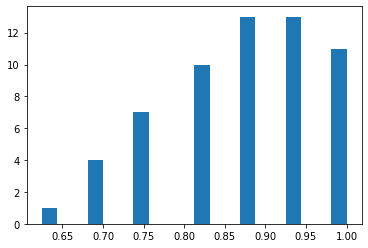

In [23]:
plt.hist(total_acc, bins=20)

In [24]:
print("Total Accuracy mean {}".format(total_acc.mean()))
print("Total Accuracy std {}".format(total_acc.std()))

Total Accuracy mean 0.8697033898305084
Total Accuracy std 0.09851125370815822


# Part 7. Layer-wise Relevance Propagation

In [49]:
df = pd.read_csv(os.path.join(result_path, dataframe_filename))
df.head()

Unnamed: 0  index                                          data_path  type  \
0           0      0  ../data/derivatives/trial_images/sub_01/heat_t...  heat   
1           1      1  ../data/derivatives/trial_images/sub_01/heat_t...  heat   
2           2      2  ../data/derivatives/trial_images/sub_01/heat_t...  heat   
3           3      3  ../data/derivatives/trial_images/sub_01/heat_t...  heat   
4           4      4  ../data/derivatives/trial_images/sub_01/heat_t...  heat   

   type_onehot subject  predicted_type_onehot model_name  \
0            1  sub_01                      1   model_01   
1            1  sub_01                      1   model_01   
2            1  sub_01                      1   model_01   
3            1  sub_01                      1   model_01   
4            1  sub_01                      1   model_01   

                                   model_weight_path  model_acc  model_loss  
0  /home/cocoan-gpu1/Documents/interpret_ml_neuro...     0.9375    0.056437  
1  /home/cocoan-gpu1/Documents/interpret_ml_neuro...     0.9375    0.056437  
2  /home/cocoan-gpu1/Documents/interpret_ml_neuro...     0.9375    0.056437  
3  /home/cocoan-gpu1/Documents/interpret_ml_neuro...     0.9375    0.056437  
4  /home/cocoan-gpu1/Documents/interpret_ml_neuro...     0.9375    0.056437

In [44]:
logo = LeaveOneGroupOut()

#sub_01 will be test set 
train_index, test_index = logo.split(X=df['data_path'], y=df['type_onehot'], groups=df['subject']=='sub_01')

train_index = train_index[1]
test_index = test_index[1]

#Load numpy array data from data path
train_X, train_y, test_X, test_y, fmri_shape = load_dat(df, train_index, test_index, transpose_index=[3,2,1,0])
print("train_X shape is {}".format(train_X.shape))
print("test_X shape is {}".format(test_X.shape))

train_X shape is (928, 68, 95, 79)
test_X shape is (16, 68, 95, 79)


Since we already checked cross-validation results, for LRP, we are going to train a model using all data.

In [47]:
train_all_index = np.concatenate((test_index, train_index))
train_all_X = np.concatenate((test_X, train_X), axis=0)
train_all_y = np.concatenate((test_y,train_y))

In [31]:
# Create & train model
model_for_lrp, score = train_model(fmri_shape, train_all_X, train_all_y, test_X, test_y, mini_batch_size=128, epochs=20, patience=20)

Train on 944 samples, validate on 16 samples
Epoch 1/20
944/944 [==============================] - 8s 9ms/step - loss: 2.1441 - acc: 0.5074 - val_loss: 0.5899 - val_acc: 0.7500
Epoch 2/20
944/944 [==============================] - 4s 5ms/step - loss: 0.7982 - acc: 0.5456 - val_loss: 0.5122 - val_acc: 0.9375
Epoch 3/20
944/944 [==============================] - 4s 5ms/step - loss: 0.6544 - acc: 0.5826 - val_loss: 0.5204 - val_acc: 0.7500
Epoch 4/20
944/944 [==============================] - 4s 5ms/step - loss: 0.5774 - acc: 0.7373 - val_loss: 0.4522 - val_acc: 0.8750
Epoch 5/20
944/944 [==============================] - 4s 5ms/step - loss: 0.5050 - acc: 0.7998 - val_loss: 0.2530 - val_acc: 0.9375
Epoch 6/20
944/944 [==============================] - 4s 5ms/step - loss: 0.4156 - acc: 0.8443 - val_loss: 0.1504 - val_acc: 1.0000
Epoch 7/20
944/944 [==============================] - 4s 5ms/step - loss: 0.3296 - acc: 0.8792 - val_loss: 0.0938 - val_acc: 1.0000
Epoch 8/20
944/944 [===========

For LRP, you can select ouput node. `'None'` means **max_activation** node and you can use specific node number like `0` or `1`

In [ ]:
import innvestigate
import innvestigate.utils as iutils
import innvestigate.utils.visualizations as ivis
import nibabel as nib

selection_index_LRP=[0,1,None]

LRP start!

LRP for avg images

In [185]:
subject_list = df['subject'].unique()
type_list = df['type'].unique()
model_wo_softmax = iutils.keras.graph.model_wo_softmax(model_for_lrp)

for selection_index in selection_index_LRP:
    # Configure analysis methods and properties
    if selection_index == None:
        method = ("lrp.epsilon",    {"epsilon": 1,"neuron_selection_mode":"max_activation"},    ivis.heatmap,    "LRP-Epsilon")
    else:    
        method = ("lrp.epsilon",    {"epsilon": 1, "neuron_selection_mode" : "index"},    ivis.heatmap,     "LRP-Epsilon")
        
    
    # Create analyzer.
    analyzer = innvestigate.create_analyzer(method[0],        # analysis method identifier
                                            model_wo_softmax, # model without softmax output
                                            **method[1])      # optional analysis parameters
    
    lrp_index = 'lrp_index_'+str(selection_index)
    lrp_result_path = os.path.join(result_path, 'LRP', lrp_index)
    
    #Making folders
    if not os.path.exists(lrp_result_path):
        os.makedirs(lrp_result_path)
        
        
    #Analyzing LRP, averaging images
    for subject in subject_list:
        for stimulus_type in type_list:
            indexed_path = df['data_path'].loc[(df['subject']==subject) & (df['type']==stimulus_type)].to_numpy()
            temp_nib_images = image.load_img(indexed_path)
            temp_avg_nib_images = image.mean_img(temp_nib_images)
            x = temp_avg_nib_images.get_fdata()
            x = x.transpose(2,1,0)

            # Add batch axis.
            x = x[None, :, :, :]

            # Analyze
            if selection_index == None:
                a = analyzer.analyze(x)
            else:
                a = analyzer.analyze(x, neuron_selection=selection_index)

            # Remove batch axis    
            a = a.squeeze() 

            trans_a = a.transpose(2,1,0)
            nib_a = nib.Nifti1Image(trans_a, temp_avg_nib_images.affine)

#             trial_info = os.path.splitext(os.path.basename(df.iloc[train_all_index[p]]['data_path']))[0]
#             subject_info = df.iloc[train_all_index[p]]['subject']

            lrp_file_name = 'LRP_' + subject + '_' + stimulus_type
            lrp_file_path = os.path.join(lrp_result_path, lrp_file_name)

            #Saving LRP results image
            nib.save(nib_a, lrp_file_path)

            print('{} is saved'.format(lrp_file_path))

../results/test2_avg_trial_lrp/LRP/lrp_index_0/LRP_sub_01_heat is saved
../results/test2_avg_trial_lrp/LRP/lrp_index_0/LRP_sub_01_reject is saved
../results/test2_avg_trial_lrp/LRP/lrp_index_0/LRP_sub_02_heat is saved
../results/test2_avg_trial_lrp/LRP/lrp_index_0/LRP_sub_02_reject is saved
../results/test2_avg_trial_lrp/LRP/lrp_index_0/LRP_sub_03_heat is saved
../results/test2_avg_trial_lrp/LRP/lrp_index_0/LRP_sub_03_reject is saved
../results/test2_avg_trial_lrp/LRP/lrp_index_0/LRP_sub_04_heat is saved
../results/test2_avg_trial_lrp/LRP/lrp_index_0/LRP_sub_04_reject is saved
../results/test2_avg_trial_lrp/LRP/lrp_index_0/LRP_sub_05_heat is saved
../results/test2_avg_trial_lrp/LRP/lrp_index_0/LRP_sub_05_reject is saved
../results/test2_avg_trial_lrp/LRP/lrp_index_0/LRP_sub_06_heat is saved
../results/test2_avg_trial_lrp/LRP/lrp_index_0/LRP_sub_06_reject is saved
../results/test2_avg_trial_lrp/LRP/lrp_index_0/LRP_sub_07_heat is saved
../results/test2_avg_trial_lrp/LRP/lrp_index_0/LRP_s

LRP for every images

In [85]:
temp_nib = image.load_img(df.iloc[0]['data_path'])
model_wo_softmax = iutils.keras.graph.model_wo_softmax(model_for_lrp)

for selection_index in selection_index_LRP:
    # Configure analysis methods and properties
    if selection_index == None:
        method = ("lrp.epsilon",    {"epsilon": 1,"neuron_selection_mode":"max_activation"},    ivis.heatmap,    "LRP-Epsilon")
    else:    
        method = ("lrp.epsilon",    {"epsilon": 1, "neuron_selection_mode" : "index"},    ivis.heatmap,     "LRP-Epsilon")
        
    
    # Create analyzer.
    analyzer = innvestigate.create_analyzer(method[0],        # analysis method identifier
                                            model_wo_softmax, # model without softmax output
                                            **method[1])      # optional analysis parameters
    
    lrp_index = 'lrp_index_'+str(selection_index)
    lrp_result_path = os.path.join(result_path, 'LRP', lrp_index)
    
    #Making folders
    if not os.path.exists(lrp_result_path):
        os.makedirs(lrp_result_path)
        
        
    #Analyzing LRP
    for p, x in enumerate(train_all_X):

        # Add batch axis.
        x = x[None, :, :, :]

        # Analyze
        if selection_index == None:
            a = analyzer.analyze(x)
        else:
            a = analyzer.analyze(x, neuron_selection=selection_index)

        # Remove batch axis    
        a = a.squeeze() 
        
        trans_a = a.transpose(2,1,0)
        nib_a = nib.Nifti1Image(trans_a, temp_nib.affine)
        
        trial_info = os.path.splitext(os.path.basename(df.iloc[train_all_index[p]]['data_path']))[0]
        subject_info = df.iloc[train_all_index[p]]['subject']
        
        lrp_file_name = 'LRP_' + subject_info + '_' + trial_info
        lrp_file_path = os.path.join(lrp_result_path, lrp_file_name)

        #Saving LRP results image
        nib.save(nib_a, lrp_file_path)
        
        print('{} is saved'.format(lrp_file_path))

../results/test2_avg_trial_lrp/LRP/lrp_index_0/LRP_sub_01_heat_trial01 is saved
../results/test2_avg_trial_lrp/LRP/lrp_index_0/LRP_sub_01_heat_trial02 is saved
../results/test2_avg_trial_lrp/LRP/lrp_index_0/LRP_sub_01_heat_trial03 is saved
../results/test2_avg_trial_lrp/LRP/lrp_index_0/LRP_sub_01_heat_trial04 is saved
../results/test2_avg_trial_lrp/LRP/lrp_index_0/LRP_sub_01_heat_trial05 is saved
../results/test2_avg_trial_lrp/LRP/lrp_index_0/LRP_sub_01_heat_trial06 is saved
../results/test2_avg_trial_lrp/LRP/lrp_index_0/LRP_sub_01_heat_trial07 is saved
../results/test2_avg_trial_lrp/LRP/lrp_index_0/LRP_sub_01_heat_trial08 is saved
../results/test2_avg_trial_lrp/LRP/lrp_index_0/LRP_sub_01_rejection_trial01 is saved
../results/test2_avg_trial_lrp/LRP/lrp_index_0/LRP_sub_01_rejection_trial02 is saved
../results/test2_avg_trial_lrp/LRP/lrp_index_0/LRP_sub_01_rejection_trial03 is saved
../results/test2_avg_trial_lrp/LRP/lrp_index_0/LRP_sub_01_rejection_trial04 is saved
../results/test2_avg

# Part 8. Visualization

Now you have lots of images resulting from LRP, which are same in number as all input data.

You can visualize mean of predicted type.

In [3]:
datasource = nio.DataGrabber()
datasource.inputs.base_directory = result_path
datasource.inputs.template = 'LRP/*None/*heat*'
datasource.inputs.sort_filelist = True
lrp_heat_avg_list = datasource.run().outputs.get()['outfiles']

datasource.inputs.template = 'LRP/*None/*reject*'
lrp_rej_avg_list = datasource.run().outputs.get()['outfiles']

In [10]:
print(np.array(lrp_heat_avg_list)[:10])
print(np.array(lrp_rej_avg_list)[:10])

['/home/cocoan-gpu1/Documents/interpret_ml_neuroimaging/results/test2_avg_trial_lrp/LRP/lrp_index_None/LRP_sub_01_heat.nii'
 '/home/cocoan-gpu1/Documents/interpret_ml_neuroimaging/results/test2_avg_trial_lrp/LRP/lrp_index_None/LRP_sub_02_heat.nii'
 '/home/cocoan-gpu1/Documents/interpret_ml_neuroimaging/results/test2_avg_trial_lrp/LRP/lrp_index_None/LRP_sub_03_heat.nii'
 '/home/cocoan-gpu1/Documents/interpret_ml_neuroimaging/results/test2_avg_trial_lrp/LRP/lrp_index_None/LRP_sub_04_heat.nii'
 '/home/cocoan-gpu1/Documents/interpret_ml_neuroimaging/results/test2_avg_trial_lrp/LRP/lrp_index_None/LRP_sub_05_heat.nii'
 '/home/cocoan-gpu1/Documents/interpret_ml_neuroimaging/results/test2_avg_trial_lrp/LRP/lrp_index_None/LRP_sub_06_heat.nii'
 '/home/cocoan-gpu1/Documents/interpret_ml_neuroimaging/results/test2_avg_trial_lrp/LRP/lrp_index_None/LRP_sub_07_heat.nii'
 '/home/cocoan-gpu1/Documents/interpret_ml_neuroimaging/results/test2_avg_trial_lrp/LRP/lrp_index_None/LRP_sub_08_heat.nii'
 '/home/

In [12]:
from nistats.second_level_model import SecondLevelModel
from nistats.thresholding import map_threshold

dm_heat_avg_lrp = pd.DataFrame([1] * len(lrp_heat_avg_list), columns=['intercept'])
heat_avg_lrp_2level = SecondLevelModel(smoothing_fwhm=5).fit(lrp_heat_avg_list, design_matrix=dm_heat_avg_lrp)
heat_avg_lrp_zmap = heat_avg_lrp_2level.compute_contrast(output_type='z_score')

dm_rej_avg_lrp = pd.DataFrame([1] * len(lrp_rej_avg_list), columns=['intercept'])
rej_avg_lrp_2level = SecondLevelModel(smoothing_fwhm=5).fit(lrp_rej_avg_list, design_matrix=dm_rej_avg_lrp)
rej_avg_lrp_zmap = rej_avg_lrp_2level.compute_contrast(output_type='z_score')

In [13]:
datasource.inputs.template = 'LRP/*None_every/*heat*'
datasource.inputs.sort_filelist = True
lrp_heat_every_list = datasource.run().outputs.get()['outfiles']

datasource.inputs.template = 'LRP/*None_every/*reject*'
lrp_rej_every_list = datasource.run().outputs.get()['outfiles']

In [14]:
print(np.array(lrp_heat_every_list)[:10])
print(np.array(lrp_rej_every_list)[:10])

['/home/cocoan-gpu1/Documents/interpret_ml_neuroimaging/results/test2_avg_trial_lrp/LRP/lrp_index_None_every/LRP_sub_01_heat_trial01.nii'
 '/home/cocoan-gpu1/Documents/interpret_ml_neuroimaging/results/test2_avg_trial_lrp/LRP/lrp_index_None_every/LRP_sub_01_heat_trial02.nii'
 '/home/cocoan-gpu1/Documents/interpret_ml_neuroimaging/results/test2_avg_trial_lrp/LRP/lrp_index_None_every/LRP_sub_01_heat_trial03.nii'
 '/home/cocoan-gpu1/Documents/interpret_ml_neuroimaging/results/test2_avg_trial_lrp/LRP/lrp_index_None_every/LRP_sub_01_heat_trial04.nii'
 '/home/cocoan-gpu1/Documents/interpret_ml_neuroimaging/results/test2_avg_trial_lrp/LRP/lrp_index_None_every/LRP_sub_01_heat_trial05.nii'
 '/home/cocoan-gpu1/Documents/interpret_ml_neuroimaging/results/test2_avg_trial_lrp/LRP/lrp_index_None_every/LRP_sub_01_heat_trial06.nii'
 '/home/cocoan-gpu1/Documents/interpret_ml_neuroimaging/results/test2_avg_trial_lrp/LRP/lrp_index_None_every/LRP_sub_01_heat_trial07.nii'
 '/home/cocoan-gpu1/Documents/inte

In [17]:
dm_heat_every_lrp = pd.DataFrame([1] * len(lrp_heat_every_list), columns=['intercept'])
heat_every_lrp_2level = SecondLevelModel(smoothing_fwhm=5).fit(lrp_heat_every_list, design_matrix=dm_heat_every_lrp)
heat_every_lrp_zmap = heat_every_lrp_2level.compute_contrast(output_type='z_score')

dm_rej_every_lrp = pd.DataFrame([1] * len(lrp_rej_every_list), columns=['intercept'])
rej_every_lrp_2level = SecondLevelModel(smoothing_fwhm=5).fit(lrp_rej_every_list, design_matrix=dm_rej_every_lrp)
rej_every_lrp_zmap = rej_every_lrp_2level.compute_contrast(output_type='z_score')

In [16]:
x_coords = [-52,-42,-30,-18,24,38,50]
y_coords = [4,8,10,20,22,28,34]
z_coords = [-22,-20,-12,-4,-2,6,14]

For plotting results, we are using `nilearn.plotting`

Details in [Plotting brain images](http://nilearn.github.io/plotting/index.html)

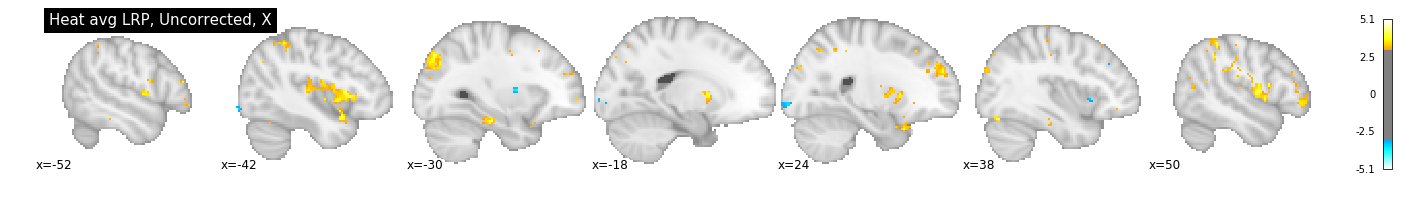

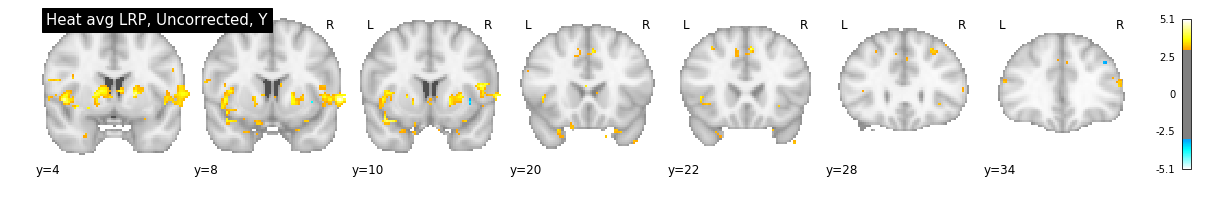

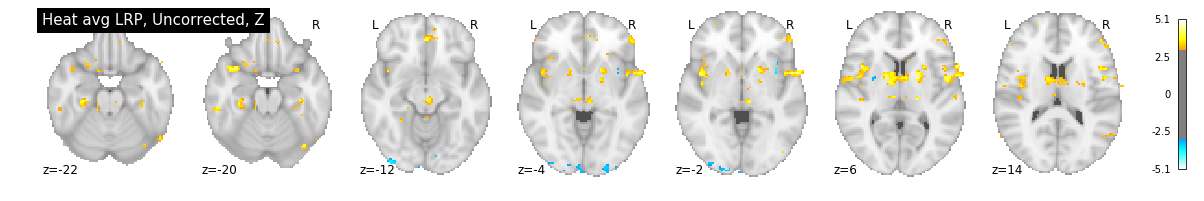

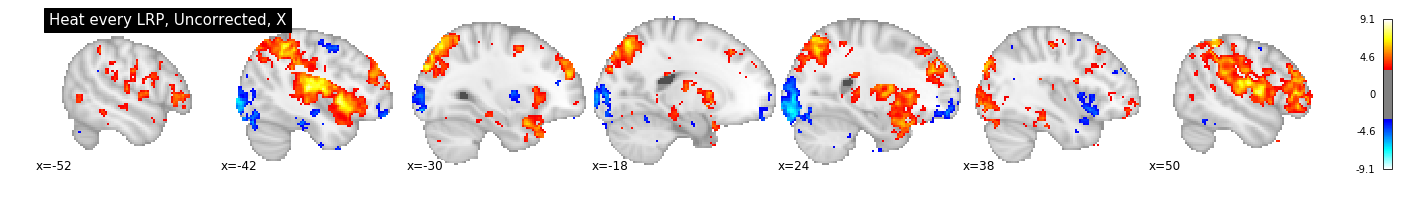

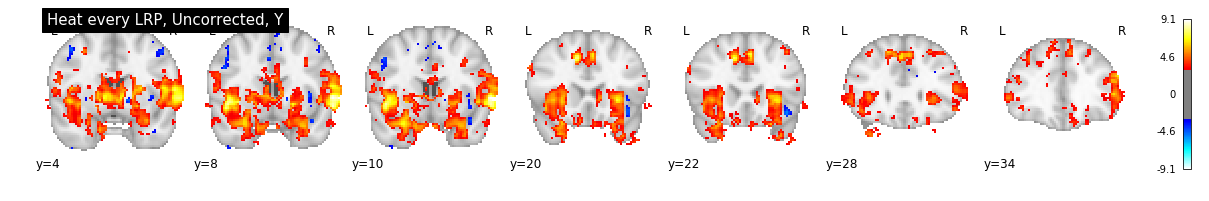

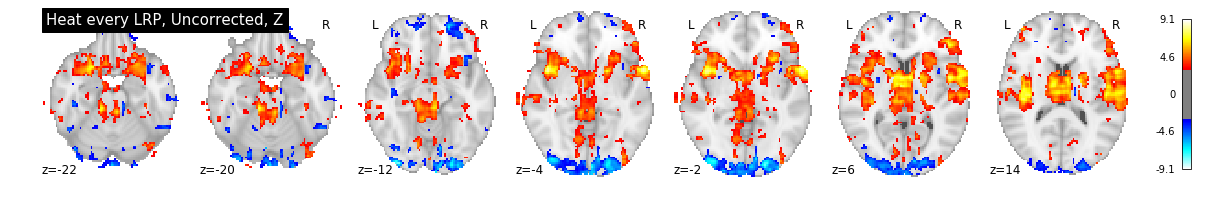

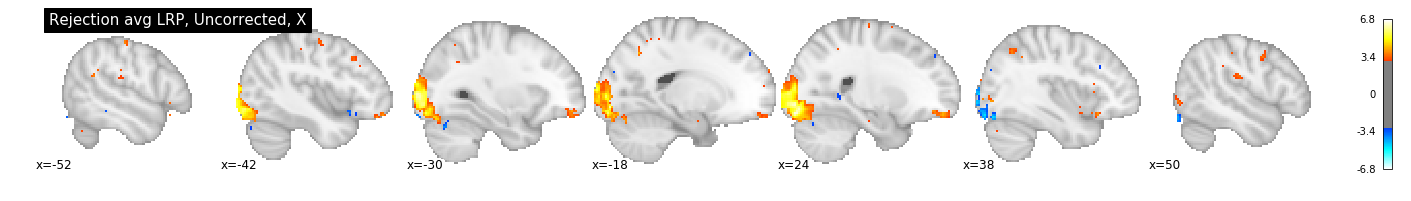

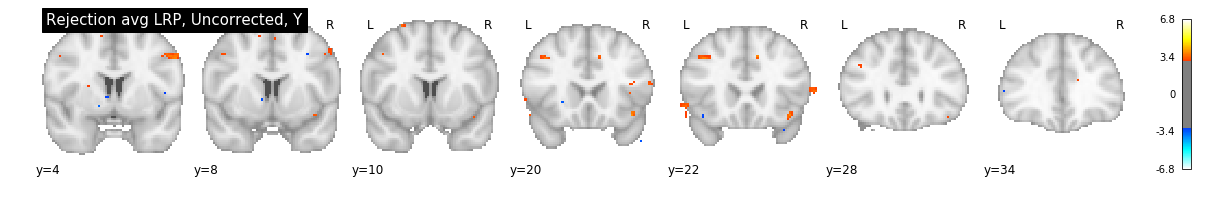

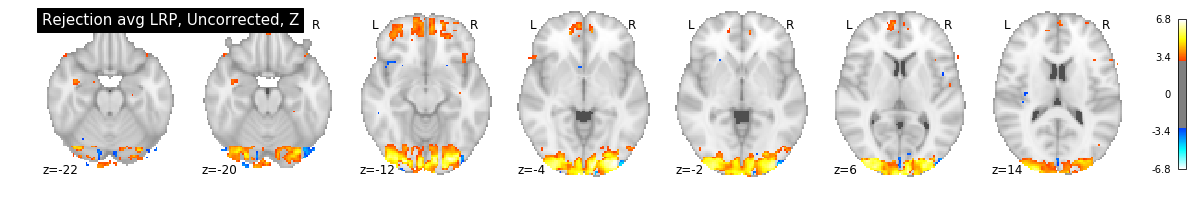

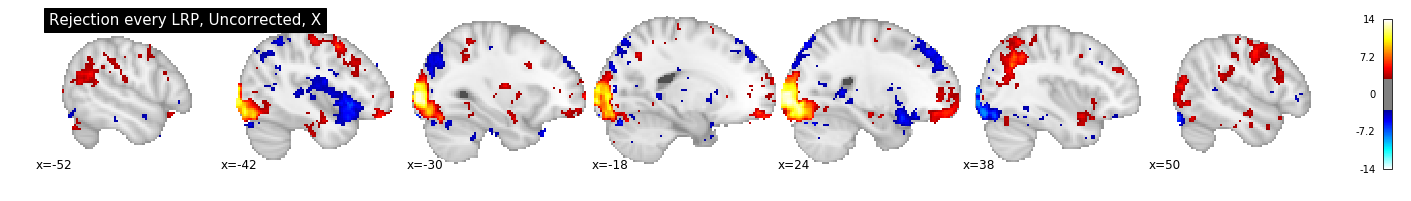

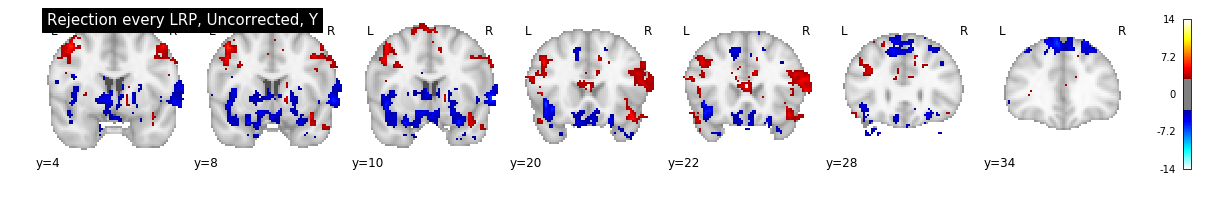

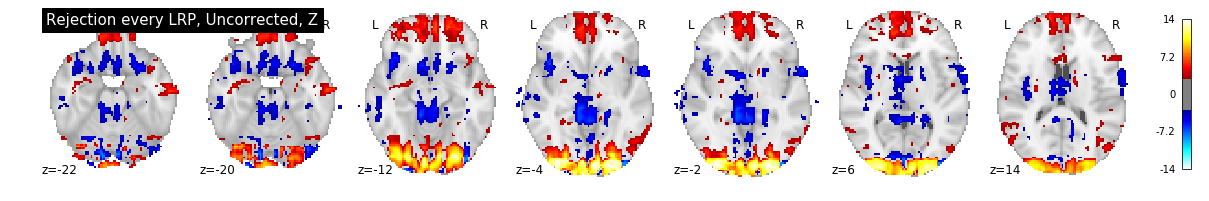

In [18]:
from nilearn import plotting
from scipy.stats import norm
p_val = 0.001
p_val_to_z_val = norm.isf(p_val)

#Plotting stat map
plotting.plot_stat_map(heat_avg_lrp_zmap, threshold=p_val_to_z_val, display_mode='x', cut_coords=x_coords, title='Heat avg LRP, Uncorrected, X')
plotting.plot_stat_map(heat_avg_lrp_zmap, threshold=p_val_to_z_val, display_mode='y', cut_coords=y_coords, title='Heat avg LRP, Uncorrected, Y')
plotting.plot_stat_map(heat_avg_lrp_zmap, threshold=p_val_to_z_val, display_mode='z', cut_coords=z_coords, title='Heat avg LRP, Uncorrected, Z')

#Plotting stat map
plotting.plot_stat_map(heat_every_lrp_zmap, threshold=p_val_to_z_val, display_mode='x', cut_coords=x_coords, title='Heat every LRP, Uncorrected, X')
plotting.plot_stat_map(heat_every_lrp_zmap, threshold=p_val_to_z_val, display_mode='y', cut_coords=y_coords, title='Heat every LRP, Uncorrected, Y')
plotting.plot_stat_map(heat_every_lrp_zmap, threshold=p_val_to_z_val, display_mode='z', cut_coords=z_coords, title='Heat every LRP, Uncorrected, Z')

#Plotting stat map
plotting.plot_stat_map(rej_avg_lrp_zmap, threshold=p_val_to_z_val, display_mode='x', cut_coords=x_coords, title='Rejection avg LRP, Uncorrected, X')
plotting.plot_stat_map(rej_avg_lrp_zmap, threshold=p_val_to_z_val, display_mode='y', cut_coords=y_coords, title='Rejection avg LRP, Uncorrected, Y')
plotting.plot_stat_map(rej_avg_lrp_zmap, threshold=p_val_to_z_val, display_mode='z', cut_coords=z_coords, title='Rejection avg LRP, Uncorrected, Z')

#Plotting stat map
plotting.plot_stat_map(rej_every_lrp_zmap, threshold=p_val_to_z_val, display_mode='x', cut_coords=x_coords, title='Rejection every LRP, Uncorrected, X')
plotting.plot_stat_map(rej_every_lrp_zmap, threshold=p_val_to_z_val, display_mode='y', cut_coords=y_coords, title='Rejection every LRP, Uncorrected, Y')
plotting.plot_stat_map(rej_every_lrp_zmap, threshold=p_val_to_z_val, display_mode='z', cut_coords=z_coords, title='Rejection every LRP, Uncorrected, Z')

In [21]:
heat_avg_lrp_fpr, heat_avg_fpr_thresh = map_threshold(heat_avg_lrp_zmap, alpha=.001, height_control='fpr', cluster_threshold=10)
heat_avg_lrp_fdr, heat_avg_fdr_thresh = map_threshold(heat_avg_lrp_zmap, alpha=.05, height_control='fdr')
heat_avg_lrp_bonfer, heat_avg_bonfer_thresh = map_threshold(heat_avg_lrp_zmap, alpha=.05, height_control='bonferroni')

rej_avg_lrp_fpr, rej_avg_fpr_thresh = map_threshold(rej_avg_lrp_zmap, alpha=.001, height_control='fpr', cluster_threshold=10)
rej_avg_lrp_fdr, rej_avg_fdr_thresh = map_threshold(rej_avg_lrp_zmap, alpha=.05, height_control='fdr')
rej_avg_lrp_bonfer, rej_avg_bonfer_thresh = map_threshold(rej_avg_lrp_zmap, alpha=.05, height_control='bonferroni')

heat_every_lrp_fpr, heat_every_fpr_thresh = map_threshold(heat_every_lrp_zmap, alpha=.001, height_control='fpr', cluster_threshold=10)
heat_every_lrp_fdr, heat_every_fdr_thresh = map_threshold(heat_every_lrp_zmap, alpha=.05, height_control='fdr')
heat_every_lrp_bonfer, heat_every_bonfer_thresh = map_threshold(heat_every_lrp_zmap, alpha=.05, height_control='bonferroni')

rej_every_lrp_fpr, rej_every_fpr_thresh = map_threshold(rej_avg_lrp_zmap, alpha=.001, height_control='fpr', cluster_threshold=10)
rej_every_lrp_fdr, rej_every_fdr_thresh = map_threshold(rej_avg_lrp_zmap, alpha=.05, height_control='fdr')
rej_every_lrp_bonfer, rej_every_bonfer_thresh = map_threshold(rej_avg_lrp_zmap, alpha=.05, height_control='bonferroni')

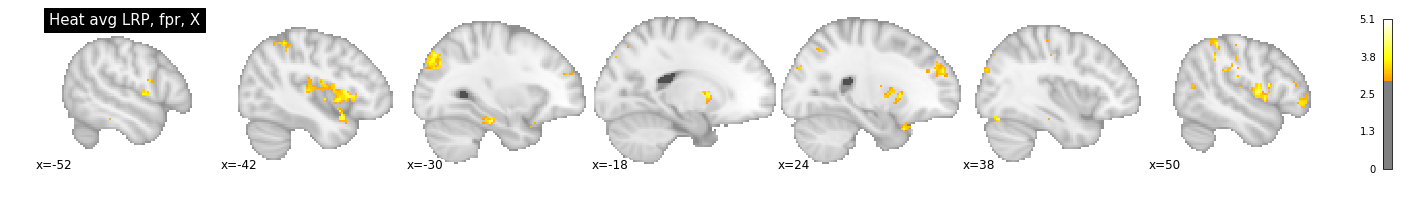

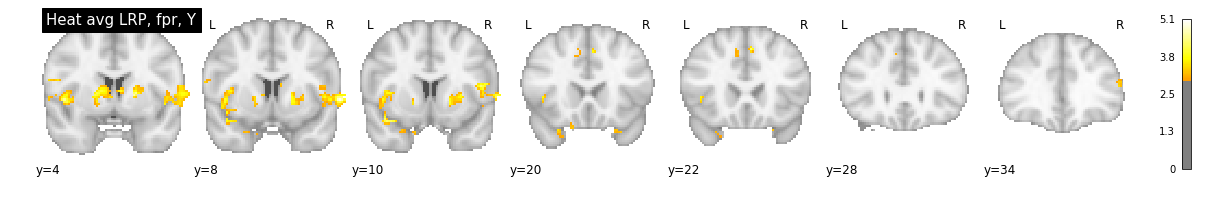

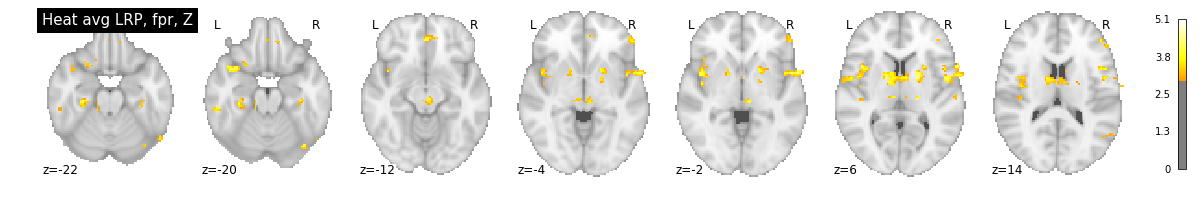

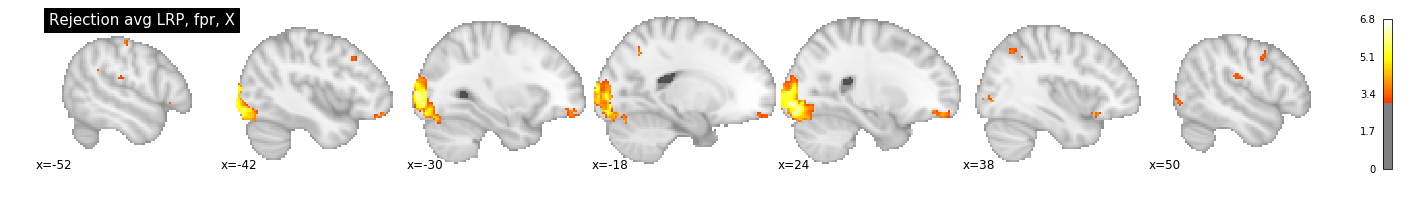

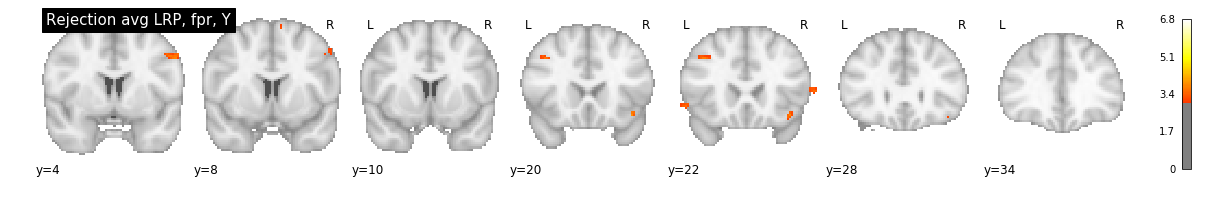

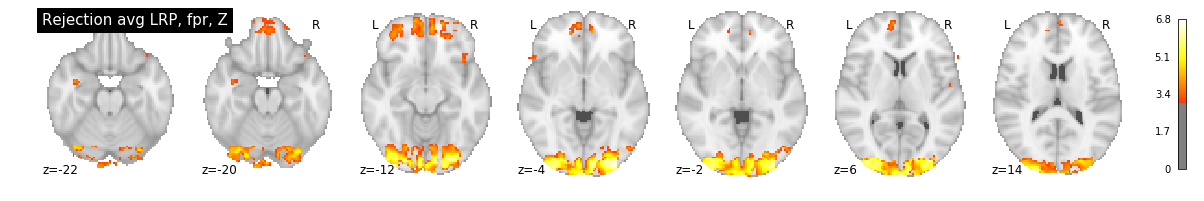

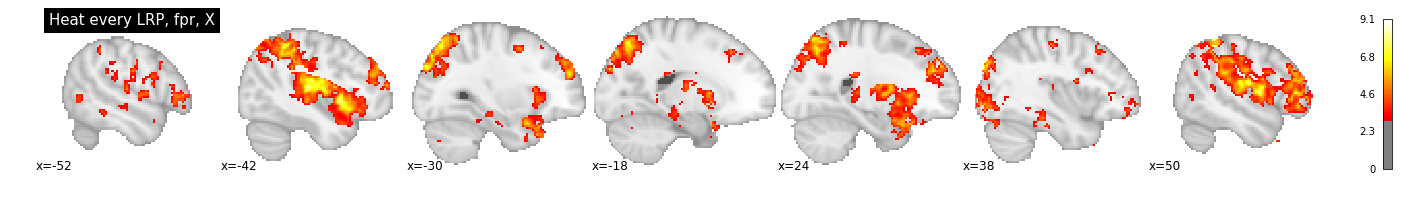

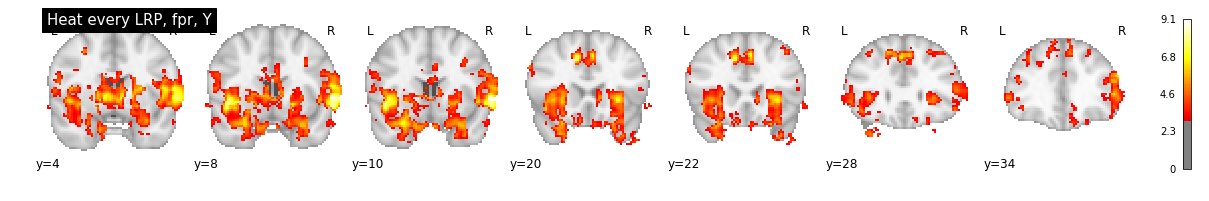

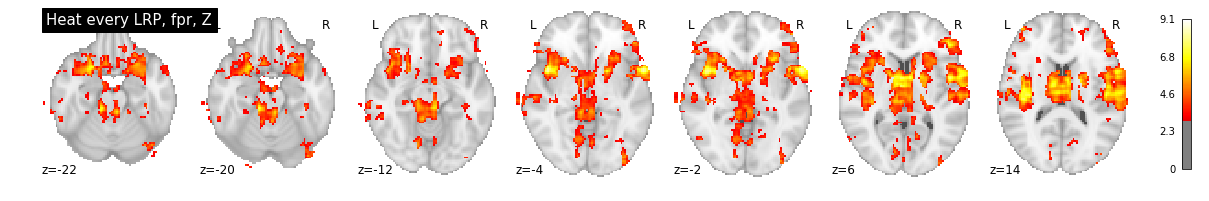

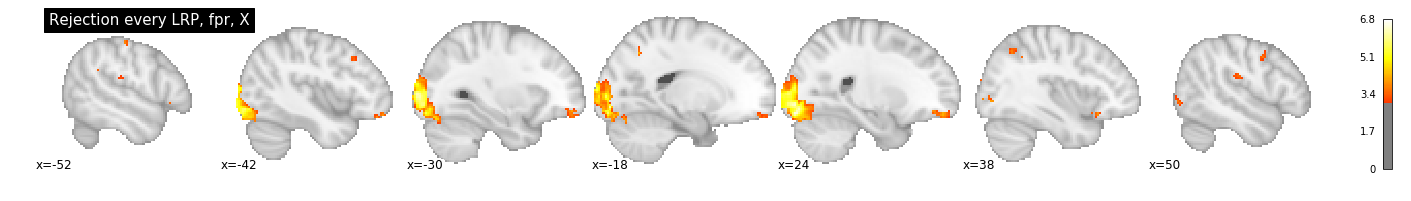

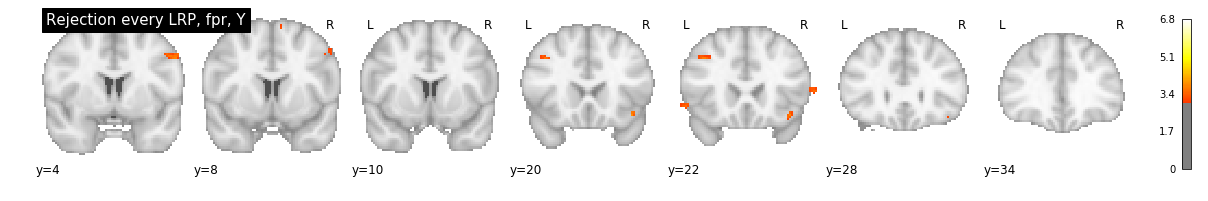

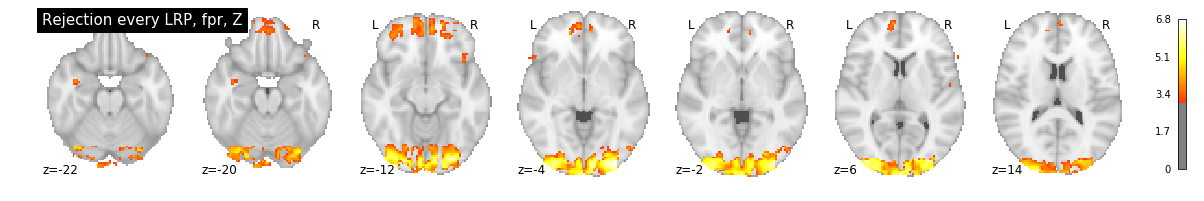

In [22]:
#Plotting stat map
plotting.plot_stat_map(heat_avg_lrp_fpr, threshold=heat_avg_fpr_thresh, display_mode='x', cut_coords=x_coords, title='Heat avg LRP, fpr, X')
plotting.plot_stat_map(heat_avg_lrp_fpr, threshold=heat_avg_fpr_thresh, display_mode='y', cut_coords=y_coords, title='Heat avg LRP, fpr, Y')
plotting.plot_stat_map(heat_avg_lrp_fpr, threshold=heat_avg_fpr_thresh, display_mode='z', cut_coords=z_coords, title='Heat avg LRP, fpr, Z')

#Plotting stat map
plotting.plot_stat_map(rej_avg_lrp_fpr, threshold=rej_avg_fpr_thresh, display_mode='x', cut_coords=x_coords, title='Rejection avg LRP, fpr, X')
plotting.plot_stat_map(rej_avg_lrp_fpr, threshold=rej_avg_fpr_thresh, display_mode='y', cut_coords=y_coords, title='Rejection avg LRP, fpr, Y')
plotting.plot_stat_map(rej_avg_lrp_fpr, threshold=rej_avg_fpr_thresh, display_mode='z', cut_coords=z_coords, title='Rejection avg LRP, fpr, Z')

#Plotting stat map
plotting.plot_stat_map(heat_every_lrp_fpr, threshold=heat_every_fpr_thresh, display_mode='x', cut_coords=x_coords, title='Heat every LRP, fpr, X')
plotting.plot_stat_map(heat_every_lrp_fpr, threshold=heat_every_fpr_thresh, display_mode='y', cut_coords=y_coords, title='Heat every LRP, fpr, Y')
plotting.plot_stat_map(heat_every_lrp_fpr, threshold=heat_every_fpr_thresh, display_mode='z', cut_coords=z_coords, title='Heat every LRP, fpr, Z')

#Plotting stat map
plotting.plot_stat_map(rej_every_lrp_fpr, threshold=rej_every_fpr_thresh, display_mode='x', cut_coords=x_coords, title='Rejection every LRP, fpr, X')
plotting.plot_stat_map(rej_every_lrp_fpr, threshold=rej_every_fpr_thresh, display_mode='y', cut_coords=y_coords, title='Rejection every LRP, fpr, Y')
plotting.plot_stat_map(rej_every_lrp_fpr, threshold=rej_every_fpr_thresh, display_mode='z', cut_coords=z_coords, title='Rejection every LRP, fpr, Z')

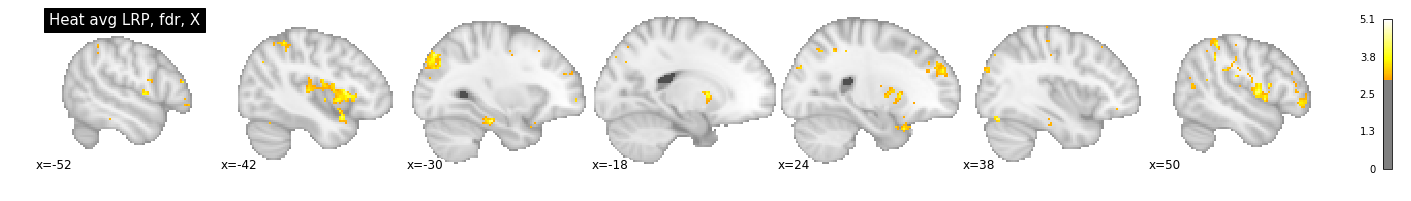

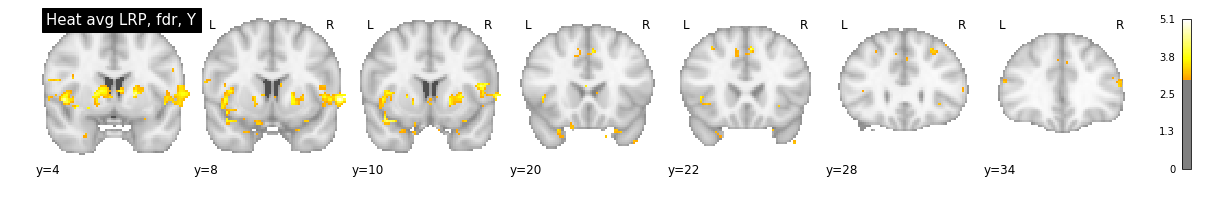

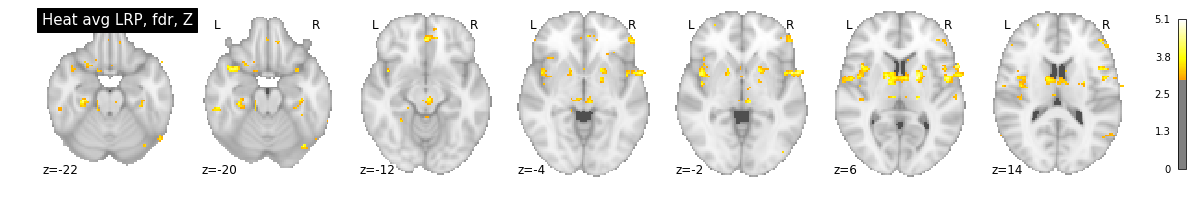

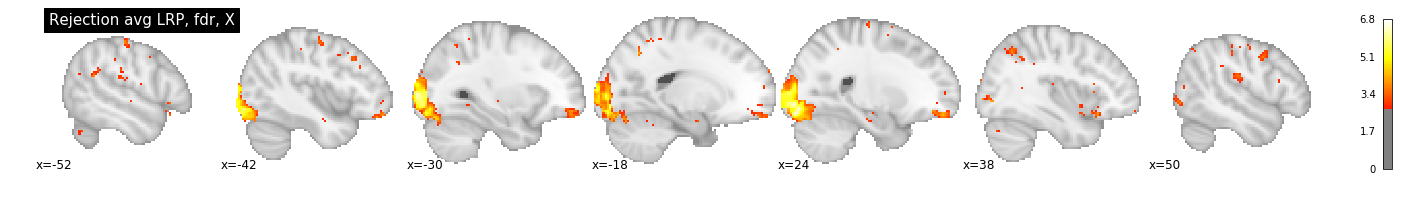

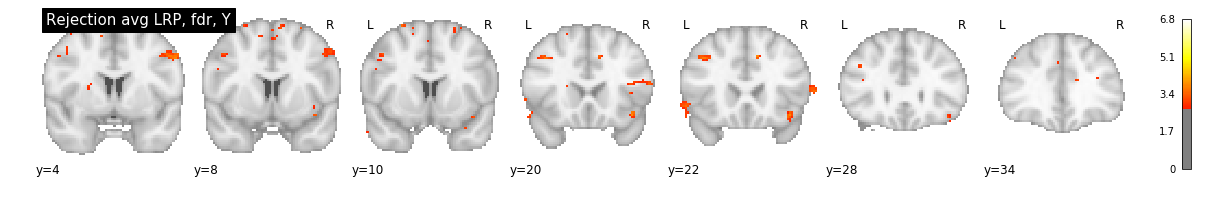

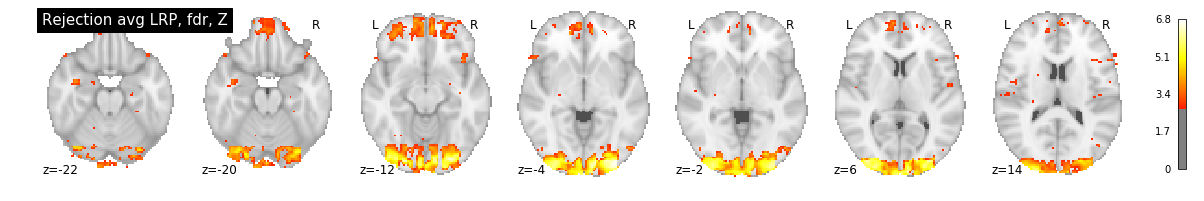

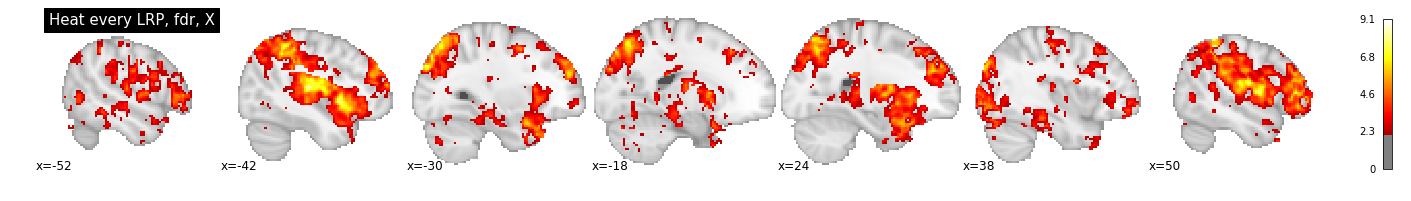

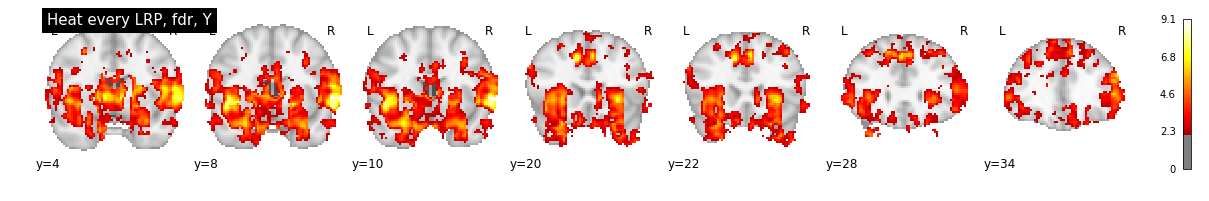

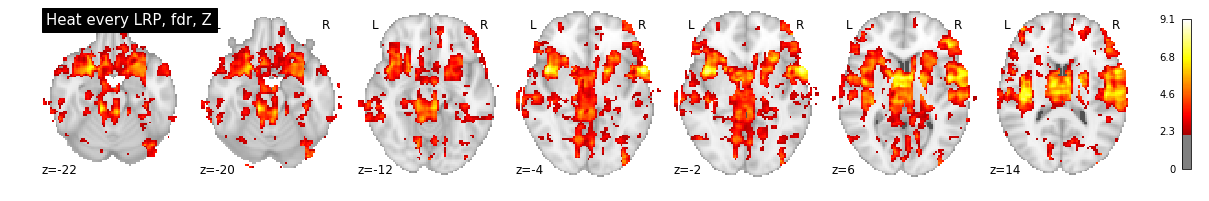

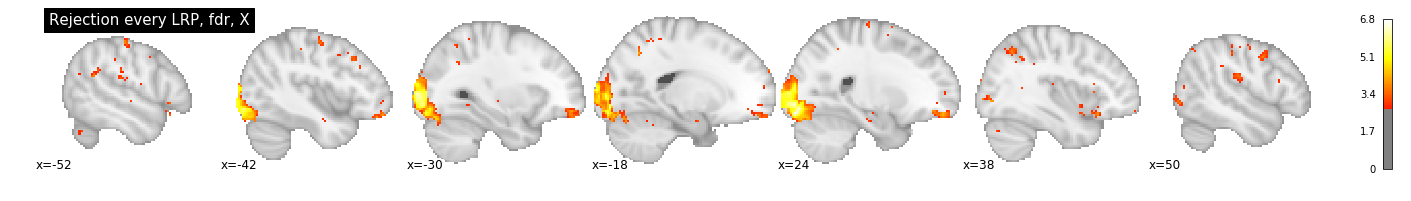

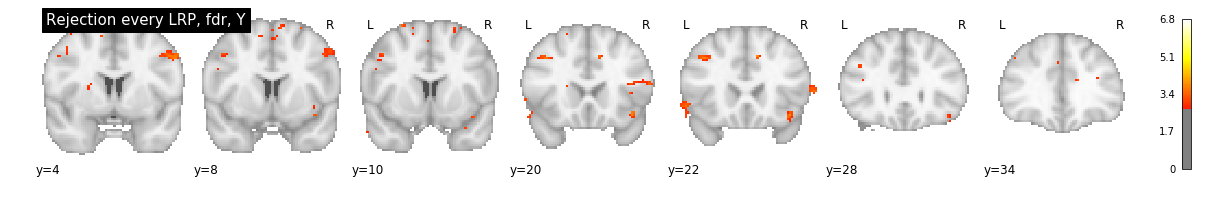

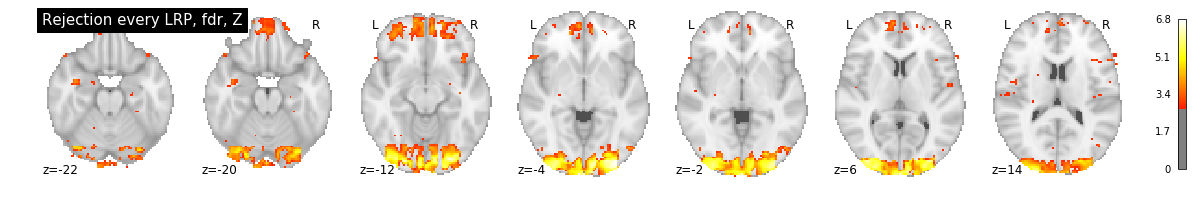

In [23]:
#Plotting stat map
plotting.plot_stat_map(heat_avg_lrp_fdr, threshold=heat_avg_fdr_thresh, display_mode='x', cut_coords=x_coords, title='Heat avg LRP, fdr, X')
plotting.plot_stat_map(heat_avg_lrp_fdr, threshold=heat_avg_fdr_thresh, display_mode='y', cut_coords=y_coords, title='Heat avg LRP, fdr, Y')
plotting.plot_stat_map(heat_avg_lrp_fdr, threshold=heat_avg_fdr_thresh, display_mode='z', cut_coords=z_coords, title='Heat avg LRP, fdr, Z')

#Plotting stat map
plotting.plot_stat_map(rej_avg_lrp_fdr, threshold=rej_avg_fdr_thresh, display_mode='x', cut_coords=x_coords, title='Rejection avg LRP, fdr, X')
plotting.plot_stat_map(rej_avg_lrp_fdr, threshold=rej_avg_fdr_thresh, display_mode='y', cut_coords=y_coords, title='Rejection avg LRP, fdr, Y')
plotting.plot_stat_map(rej_avg_lrp_fdr, threshold=rej_avg_fdr_thresh, display_mode='z', cut_coords=z_coords, title='Rejection avg LRP, fdr, Z')

#Plotting stat map
plotting.plot_stat_map(heat_every_lrp_fdr, threshold=heat_every_fdr_thresh, display_mode='x', cut_coords=x_coords, title='Heat every LRP, fdr, X')
plotting.plot_stat_map(heat_every_lrp_fdr, threshold=heat_every_fdr_thresh, display_mode='y', cut_coords=y_coords, title='Heat every LRP, fdr, Y')
plotting.plot_stat_map(heat_every_lrp_fdr, threshold=heat_every_fdr_thresh, display_mode='z', cut_coords=z_coords, title='Heat every LRP, fdr, Z')

#Plotting stat map
plotting.plot_stat_map(rej_every_lrp_fdr, threshold=rej_every_fdr_thresh, display_mode='x', cut_coords=x_coords, title='Rejection every LRP, fdr, X')
plotting.plot_stat_map(rej_every_lrp_fdr, threshold=rej_every_fdr_thresh, display_mode='y', cut_coords=y_coords, title='Rejection every LRP, fdr, Y')
plotting.plot_stat_map(rej_every_lrp_fdr, threshold=rej_every_fdr_thresh, display_mode='z', cut_coords=z_coords, title='Rejection every LRP, fdr, Z')

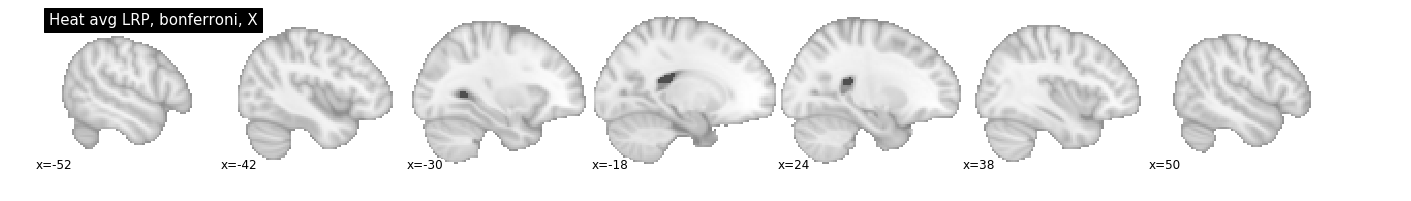

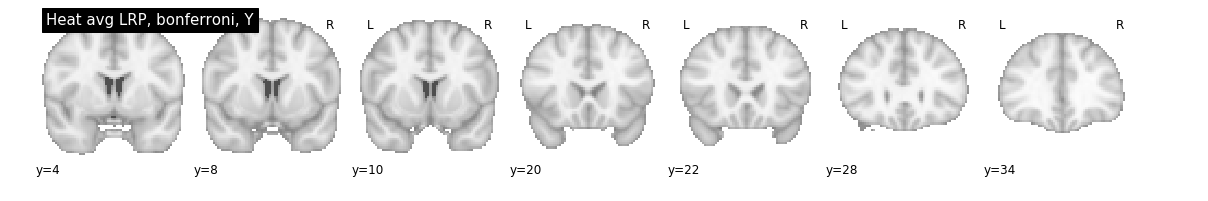

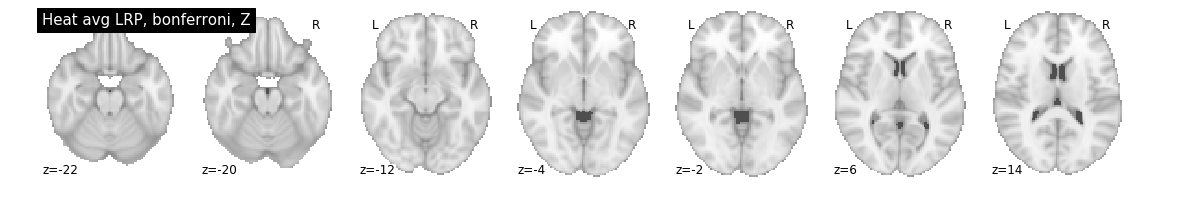

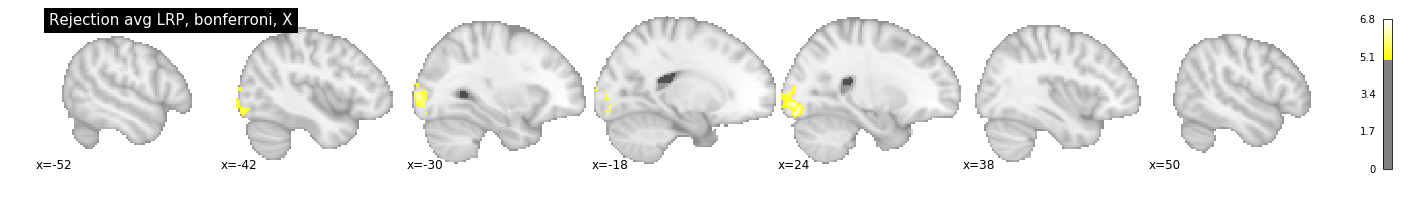

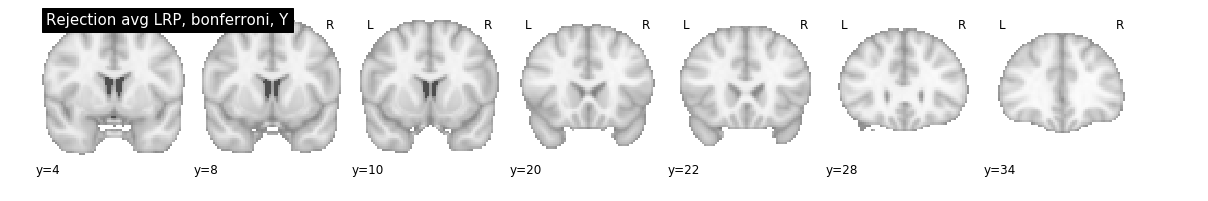

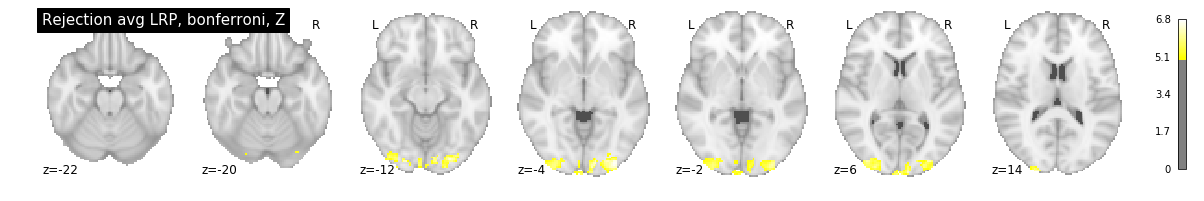

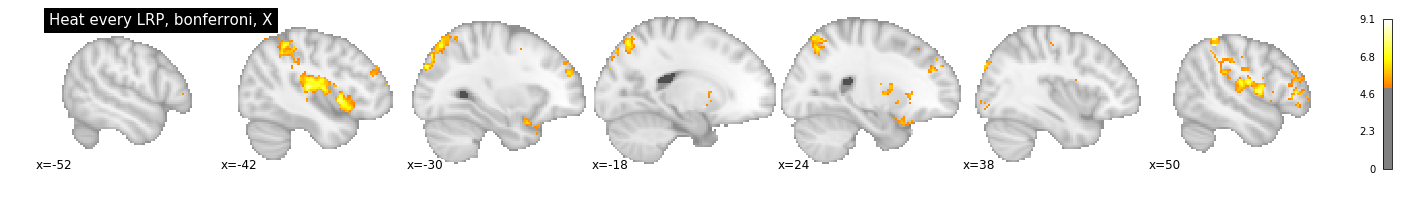

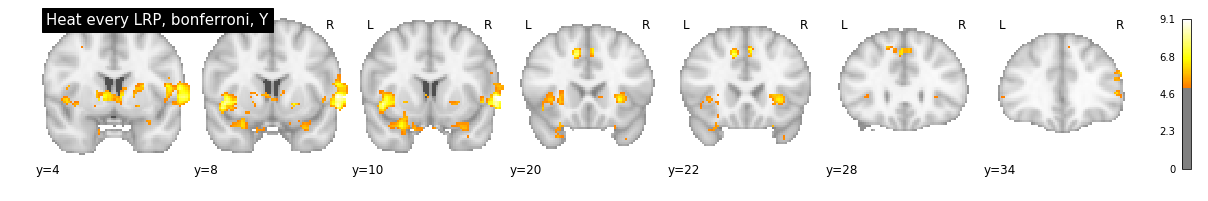

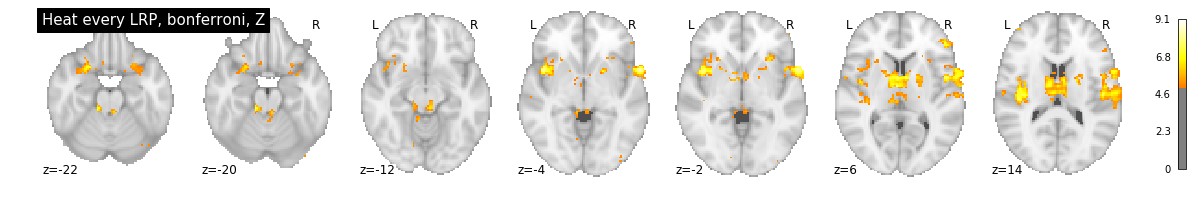

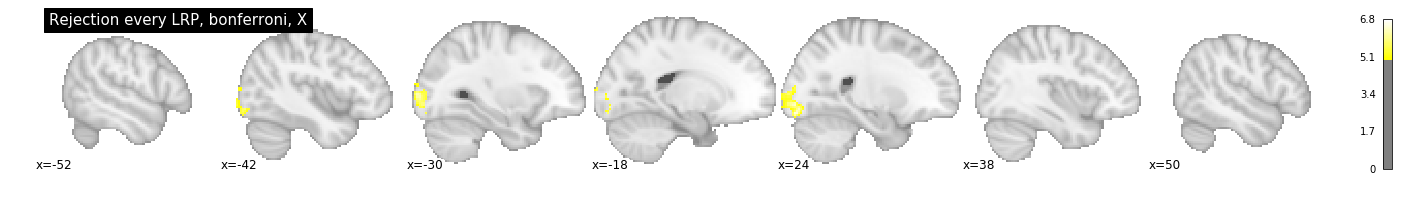

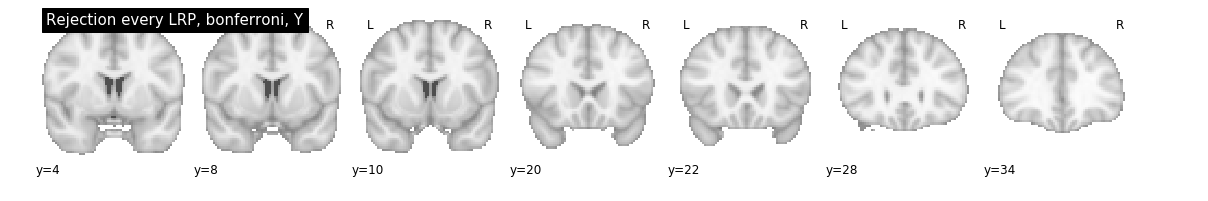

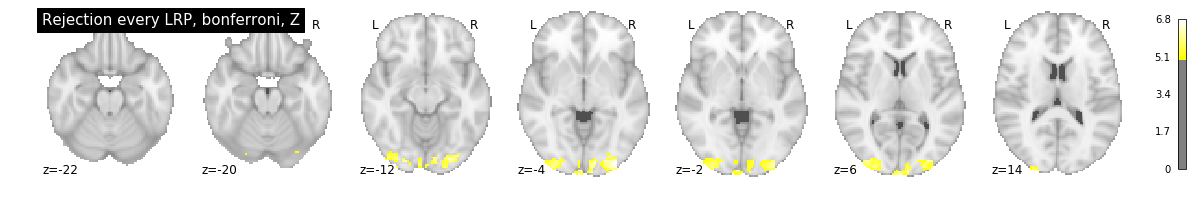

In [24]:
#Plotting stat map
plotting.plot_stat_map(heat_avg_lrp_bonfer, threshold=heat_avg_bonfer_thresh, display_mode='x', cut_coords=x_coords, title='Heat avg LRP, bonferroni, X')
plotting.plot_stat_map(heat_avg_lrp_bonfer, threshold=heat_avg_bonfer_thresh, display_mode='y', cut_coords=y_coords, title='Heat avg LRP, bonferroni, Y')
plotting.plot_stat_map(heat_avg_lrp_bonfer, threshold=heat_avg_bonfer_thresh, display_mode='z', cut_coords=z_coords, title='Heat avg LRP, bonferroni, Z')

#Plotting stat map
plotting.plot_stat_map(rej_avg_lrp_bonfer, threshold=rej_avg_bonfer_thresh, display_mode='x', cut_coords=x_coords, title='Rejection avg LRP, bonferroni, X')
plotting.plot_stat_map(rej_avg_lrp_bonfer, threshold=rej_avg_bonfer_thresh, display_mode='y', cut_coords=y_coords, title='Rejection avg LRP, bonferroni, Y')
plotting.plot_stat_map(rej_avg_lrp_bonfer, threshold=rej_avg_bonfer_thresh, display_mode='z', cut_coords=z_coords, title='Rejection avg LRP, bonferroni, Z')

#Plotting stat map
plotting.plot_stat_map(heat_every_lrp_bonfer, threshold=heat_every_bonfer_thresh, display_mode='x', cut_coords=x_coords, title='Heat every LRP, bonferroni, X')
plotting.plot_stat_map(heat_every_lrp_bonfer, threshold=heat_every_bonfer_thresh, display_mode='y', cut_coords=y_coords, title='Heat every LRP, bonferroni, Y')
plotting.plot_stat_map(heat_every_lrp_bonfer, threshold=heat_every_bonfer_thresh, display_mode='z', cut_coords=z_coords, title='Heat every LRP, bonferroni, Z')

#Plotting stat map
plotting.plot_stat_map(rej_every_lrp_bonfer, threshold=rej_every_bonfer_thresh, display_mode='x', cut_coords=x_coords, title='Rejection every LRP, bonferroni, X')
plotting.plot_stat_map(rej_every_lrp_bonfer, threshold=rej_every_bonfer_thresh, display_mode='y', cut_coords=y_coords, title='Rejection every LRP, bonferroni, Y')
plotting.plot_stat_map(rej_every_lrp_bonfer, threshold=rej_every_bonfer_thresh, display_mode='z', cut_coords=z_coords, title='Rejection every LRP, bonferroni, Z')

In order to make nibabel object, you need to have base Nifti file's affine matrix and header

Details in [Nibabel images](https://nipy.org/nibabel/nibabel_images.html)

For plotting results, we are using `nilearn.plotting`

Details in [Plotting brain images](http://nilearn.github.io/plotting/index.html)

In [11]:
#plotting surface stat map
from nilearn import datasets, surface
fsaverage = datasets.fetch_surf_fsaverage()

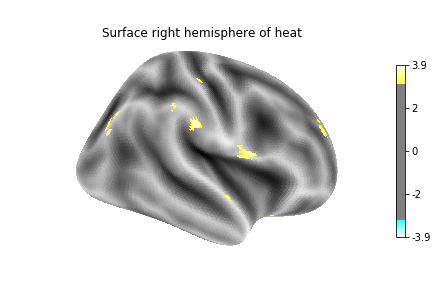

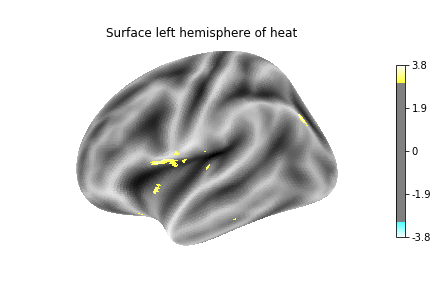

In [13]:
heat_right = surface.vol_to_surf(heat_lrp_zmap, fsaverage.pial_right)
heat_left = surface.vol_to_surf(heat_lrp_zmap, fsaverage.pial_left)

plotting.plot_surf_stat_map(fsaverage.infl_right, heat_right, hemi='right',
                            title='Surface right hemisphere of heat', colorbar=True,
                            threshold=p_val_to_z_val, bg_map=fsaverage.sulc_right)

plotting.plot_surf_stat_map(fsaverage.infl_left, heat_left, hemi='left',
                            title='Surface left hemisphere of heat', colorbar=True,
                            threshold=p_val_to_z_val, bg_map=fsaverage.sulc_left)
plotting.show()

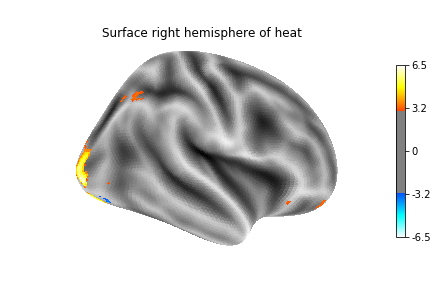

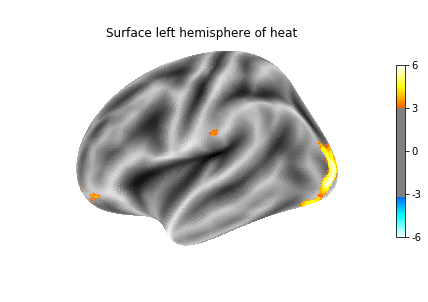

In [15]:
rej_right = surface.vol_to_surf(rej_lrp_zmap, fsaverage.pial_right)
rej_left = surface.vol_to_surf(rej_lrp_zmap, fsaverage.pial_left)

plotting.plot_surf_stat_map(fsaverage.infl_right, rej_right, hemi='right',
                            title='Surface right hemisphere of heat', colorbar=True,
                            threshold=p_val_to_z_val, bg_map=fsaverage.sulc_right)

plotting.plot_surf_stat_map(fsaverage.infl_left, rej_left, hemi='left',
                            title='Surface left hemisphere of heat', colorbar=True,
                            threshold=p_val_to_z_val, bg_map=fsaverage.sulc_left)
plotting.show()